In [1]:
from __future__ import division
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import time, os, math, warnings
from matplotlib import pyplot

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.utils import plot_model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set up some global variables
#USE_GPU = True

#if USE_GPU:
    #device = '/device:GPU:0'
#else:
    #device = '/cpu:0'

# Constant to control how often we print when training models
#print_every = 100

#print('Using device: ', device)

### Pre-processing Functions

In [3]:
def create_timeblock(X, Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Y[i + look_back, :])
    print('# of data: ', len(dataY))
    return np.array(dataX), np.array(dataY)

### Plotting Functions

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def load_data(filename):
    """
    This function reads csv file from the given url and extracts time-series data of oil & water rate,
    pressure, and water cut.
    :param filename: the url of csv file (stored in GitHub)
    :return: t: vector of time; qo: matrix of oil rate in all wells; qo: matrix of water rate in all wells;
            and p: matrix of bottom hole pressure in all wells
    """
    df = pd.read_csv(filename)

    t = df.loc[:, ['TIME']] # Time in simulation: DAY
    t *= 24 # Converting time from DAY to HOUR
    qo = df.loc[:, ['WOPR:P1', 'WOPR:P2', 'WOPR:P3']]
    qw = df.loc[:, ['WWPR:P1', 'WWPR:P2', 'WWPR:P3']]
    p = df.loc[:, ['WBHP:P1', 'WBHP:P2', 'WBHP:P3']]
    wc = df.loc[:, ['WWCT:P1', 'WWCT:P2', 'WWCT:P3']]
    return t, qo, qw, wc, p

def plot_pressure(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_pred_rate(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Flow Rate (STB/d)", fontsize=14)
    plt.title("Flow Rate Well " +str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_rates(t, q, wellname, color, label):
    """This function plots actual flow rates"""
    # Plotting Flow Rate v time
    plt.plot(t, q, color, linewidth=3, label=label)
    plt.xlabel("Time (hours)", fontsize=11)
    plt.ylabel("Flow Rate (STB/D)", fontsize=11)
    plt.title('Flow Rate Well ' + wellname, y=0.82, fontsize=9)
    plt.legend(loc=1, prop=dict(size=8))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q) + 10)
    plt.grid(True)

def plot_pressure_rates(x, y, y_pred, labelname):
    """This function plots both pressure and actual flow rates"""
    plt.figure()
    if labelname=='Training Data':
        color='red'
    else:
        color='green'

    plt.subplot(411)
    plot_pressure(x['TIME'], y, y_pred, labelname, color)

    plt.subplot(412)
    plot_rates(x['TIME'], x['WWPR:P1'], wellname='A', color='blue', label='Water Rate')
    plot_rates(x['TIME'], x['WOPR:P1'], wellname='A', color='green', label='Oil Rate')
    plt.ylim(0, max(max(x['WWPR:P1'].values), max(x['WOPR:P1'].values)) + 10)

    plt.subplot(413)
    plot_rates(x['TIME'], x['WOPR:P2'],wellname='B',color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P2'],wellname='B',color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P2'].values), max(x['WOPR:P2'].values)) + 10)

    plt.subplot(414)
    plot_rates(x['TIME'], x['WOPR:P3'], wellname='C', color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P3'], wellname='C', color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P3'].values), max(x['WOPR:P3'].values)) + 10)

def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()

def plot_loss_comparison(histories):
    plt.figure()
    plt.plot(histories['Simple RNN'].history['val_loss'], linewidth=3, label='Simple RNN')
    plt.plot(histories['GRU'].history['val_loss'], linewidth=3, label='GRU')
    plt.plot(histories['LSTM'].history['val_loss'], linewidth=3, label='LSTM')
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title(' Dev Loss', fontsize=15)
    plt.xlim(0, len(histories['Simple RNN'].history['loss']))
    plt.ylim(0, 0.02)
    plt.show()


### Load Data

In [5]:
t, qo, qw, wc, p = load_data('https://raw.githubusercontent.com/titaristanto/data-driven-production-problem/master/close_highWC_long.csv')


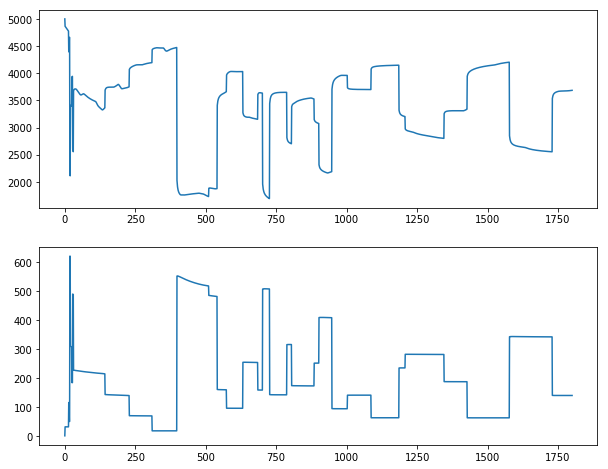

In [6]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
ax[0].plot(t,p['WBHP:P1'] )
ax[1].plot(t,qo['WOPR:P1'])

In [7]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected = True)
trace1 = go.Scatter(x = t,
                   y = p['WBHP:P1'],
                   name = "BHP")
trace2 = go.Scatter(x = t,
                   y = qo['WOPR:P1'],
                   name = "Oil rate")
data = [trace1, trace2]
layout = {"title": "B"}
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

TypeError: Object of type 'DataFrame' is not JSON serializable

# Flow Rate Prediction

### Pre-processing

In [8]:
# Group the input
X_raw = pd.concat([p['WBHP:P1'], p['WBHP:P2'], p['WBHP:P3']], axis=1, join='inner')
Y_raw = pd.concat([qo['WOPR:P1'], qo['WOPR:P2'], qo['WOPR:P3']], axis=1, join='inner')

# Split train-dev and test sets
test_fraction = 0.15
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(X_raw,
                                                  Y_raw,
                                                  test_size=test_fraction,
                                                  shuffle=False)

# Split train and dev sets
dev_fraction = 0.15 # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(x_traindev_raw,
                                                  y_traindev_raw,
                                                  test_size= dev_fraction/(1-test_fraction),
                                                  shuffle=False)

# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.as_matrix())
x_dev_norm = scaler_x.transform(x_dev_raw.as_matrix())
x_test_norm = scaler_x.transform(x_test_raw.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.as_matrix())
y_dev_norm = scaler_y.transform(y_dev_raw.as_matrix())
y_test_norm = scaler_y.transform(y_test_raw.as_matrix())

# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)


# of data:  1235
# of data:  245
# of data:  246


In [9]:
print(x_train.shape[1], x_train.shape[2])

25 3


In [10]:
x_train.shape[0]

1235

In [11]:
y_train.shape

(1235, 3)

In [ ]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=500, batch_size=400, method='LSTM'):
    classifier = {'GRU' : GRU,
                  'LSTM' : LSTM,
                  'Simple RNN' : SimpleRNN}


    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](512, return_sequences=True)(inputs)
    X = classifier[method](1024, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    X = Dropout(0.4)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X))
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    
    model = Model(input=inputs, output=[out1, out2, out3])
    
    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, [y_dev[:, 0], y_dev[:, 1], y_dev[:, 2]]), 
                        verbose=1, shuffle=False)
    return model, history

model_LSTM, history_LSTM = run_model(x_train, y_train, x_val, y_val, epochs=300, batch_size=400, method='LSTM')

In [ ]:
model_LSTM, history_LSTM = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=32, method='LSTM')

In [ ]:
# Training
y_pred_train_pre = model_LSTM.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_LSTM.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_LSTM.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

In [ ]:
plot_loss(history_LSTM, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

In [ ]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

GRU

In [ ]:
model_GRU, history_GRU = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='GRU')

# Training
y_pred_train_pre = model_GRU.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_GRU.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_GRU.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

plot_loss(history_GRU, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

Simple RNN

In [ ]:
import time
start_time = time.time()
model_RNN, history_RNN = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='Simple RNN')
# Measure running time
print("Completed in %s seconds" % (time.time() - start_time))

# Training
y_pred_train_pre = model_RNN.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_RNN.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_RNN.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

plot_loss(history_RNN, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

In [ ]:
histories = {'Simple RNN': history_RNN,
            'GRU': history_GRU,
            'LSTM': history_LSTM}
plot_loss_comparison(histories)

## BHP Prediction

In [ ]:
# Group the input
Y_raw = pd.concat([p['WBHP:P1'], p['WBHP:P2'], p['WBHP:P3']], axis=1, join='inner')
X_raw = pd.concat([qo['WOPR:P1'], qo['WOPR:P2'], qo['WOPR:P3'],
                   qw['WWPR:P1'], qw['WWPR:P2'], qw['WWPR:P3'],
                   wc['WWCT:P1'], wc['WWCT:P2'], wc['WWCT:P3']], axis=1, join='inner')

# Split train-dev and test sets
test_fraction = 0.15
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(X_raw,
                                                  Y_raw,
                                                  test_size=test_fraction,
                                                  shuffle=False)

# Split train and dev sets
dev_fraction = 0.15 # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(x_traindev_raw,
                                                  y_traindev_raw,
                                                  test_size= dev_fraction/(1-test_fraction),
                                                  shuffle=False)

# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.as_matrix())
x_dev_norm = scaler_x.transform(x_dev_raw.as_matrix())
x_test_norm = scaler_x.transform(x_test_raw.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.as_matrix())
y_dev_norm = scaler_y.transform(y_dev_raw.as_matrix())
y_test_norm = scaler_y.transform(y_test_raw.as_matrix())

# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)

In [ ]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=500, batch_size=400, method='LSTM'):
    classifier = {'GRU' : GRU,
                  'LSTM' : LSTM,
                  'Simple RNN' : SimpleRNN}

    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](512, return_sequences=True)(inputs)
    X = classifier[method](1024, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    #X = Dropout(0.6)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X))
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    
    model = Model(input=inputs, output=[out1, out2, out3])
    
    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, [y_dev[:, 0], y_dev[:, 1], y_dev[:, 2]]), 
                        verbose=1, shuffle=False)
    return model, history

In [ ]:
model, history = run_model(x_train, y_train, x_dev, y_dev, epochs=1000, batch_size=200, method='LSTM')

In [ ]:
# Training
y_pred_train_pre = model.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

In [ ]:
plot_loss(history, title='test')
plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

In [ ]:


for i in range(y_act.shape[1]):
    plot_pressure(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('plot_LSTM_512_1024_lb25_well_' + str(i))

In [ ]:
plot_model(model)

In [ ]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [ ]:
def plot_pressure_actual(t, q_actual, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual Bottom Hole Pressure')

    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q_actual) + 10)
    plt.grid(True)

for i in range(y_act.shape[1]):
    plot_pressure_actual(t[-len(y_act):].as_matrix(),
                   y_act[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    #plt.savefig('plot_LSTM_512_1024_lb25_well_' + str(i))

In [ ]:
# Training

y_train_act = scaler_y.inverse_transform(y_train)

# Dev

y_dev_act = scaler_y.inverse_transform(y_dev)

# Test

y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])


In [ ]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Files in Drive:')
!ls drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > drive/created.txt

In [ ]:
os.chdir('drive/Stanford')
os.getcwd()
